Перейти к <a href=#bookmark_code> закладка в коде </a>

# <center>Проект 6. Выбираем авто выгодно </center>

<center>Работу выполнил Алексей Дегтерев.</center>

<center>Образовательная платформа SkillFactory, </center>
<center>специализация Data Science</center>

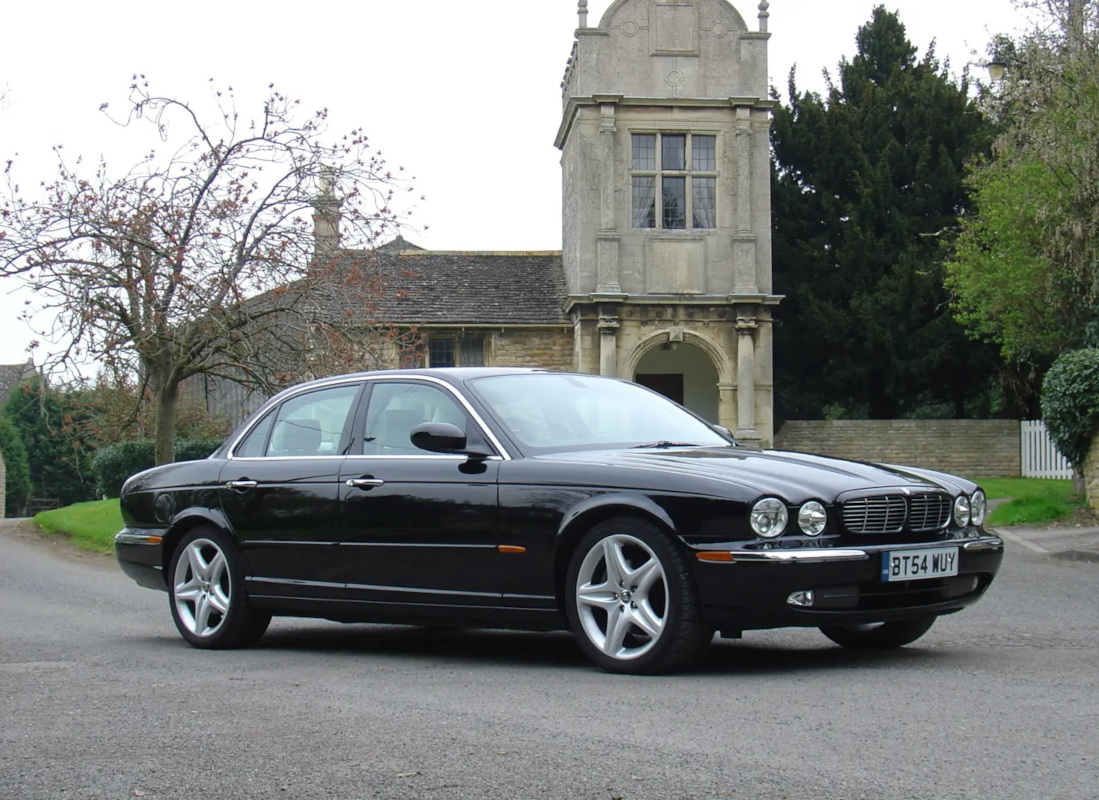

**Описание**: существует рынок подержанных автомобилей. Для каждого конкретного представленного авто есть цена, выставленная продавцом. В совокупности эти цены формируют и среднюю по рынку цену для автомобиля определенной конфигурации. Если научиться определять "корректную" с точки зрения рынка цену автомобиля, можно искать потенциально выгодные предложения - когда продавец выставил цену ниже рыночной.\
**Цель**: построить модель, которая предсказывала бы стоимость автомобиля заданной концфигурации.\
**Задачи**:
1. Получить достаточный набор данных для обучения модели (спарсить с сайта объявлений, в данном случае auto.ru) - код представлен отдельным JupyterNotebook на Github. Код не совсем мой, адаптированный для решения задачи.
2. Построить и обучить модель предсказания цены автомобиля

## Предварительные действия

Подготовка к работе: импортируем нужные библиотеки, задаем значения констант и путей

In [1]:
import numpy as np 
import pandas as pd 
import sys, os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from pprint import pprint
import logging

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Зададим управляющие переменные

закладка: управляющие переменные <a name='bookmark_1' />

In [3]:
# зафиксируем стартовое значение для ГСЧ
RANDOM_SEED = 42
# запускаем notebook на Kaggle или локально
IS_RUN_ON_KAGGLE = False
# номер рабочей версии
VERSION    = 9

VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 500 #2000
LR         = 0.1

WRITE_LOGS = True
run_cat_boost_single = False
run_cat_boost_cross_validation = False
run_cat_boost_grid_search = True
run_random_forest_regressor = False
run_y_log_processing = True
run_cat_columns_encoding = True # for Random_forest_regressor

Описание префиксов для переменных и логирования:

run_ - префикс для управляющих переменных, ответственных за включение определенных моделей и алгоритмов обработки данных во время запуска

model_ver_ - префикс для обозначения переменных логирования номера версии обработки данных

Перейти к <a href=#bookmark_code> закладка в коде </a>

In [4]:
if IS_RUN_ON_KAGGLE:
    DIR_TRAIN  = '../input/proj5-data/cars_from_auto_ru_06_02/'
    DIR_TEST   = '../input/proj5-data/test.csv/'
    DIR_SUBMISSION = '../input/proj5-data/'
else:
    NOTEBOOK_PATH = os.getcwd()
    DIR_TRAIN  = NOTEBOOK_PATH + '/data/'
    DIR_TEST   = NOTEBOOK_PATH + '/data/'
    DIR_SUBMISSION = NOTEBOOK_PATH + '/data/'

CONST_OTHER_NAME = 'другое'

In [5]:
logging.basicConfig(filename='model_params.log', 
                    format='[%(asctime)s] [%(levelname)s] => %(message)s', 
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

In [6]:
# разделяющая строка для логов, чтобы было удобнее читать их
if WRITE_LOGS:
    logging.info('==ver_{0}== \n'.format(VERSION))

## Импорт данных

In [7]:
# мой подготовленный датасет для обучения модели
train = pd.read_csv(DIR_TRAIN+'cars_from_auto_ru_06_02.csv') 

# тестовый датасет, доступный на платформе
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_SUBMISSION+'sample_submission.csv')

Рассмотрим доступный тестовый датасет, какие в нем хранятся данные. 

In [8]:
def show_df_info(input_df):
    '''
    Функция, показывающая расширенное описание DataFrame. Показывет количество
    пропущенных значений, а также их процентную долю.
    '''
    df = pd.DataFrame([
        input_df.columns,
        input_df.count().values,
        input_df.isnull().sum(),
        input_df.isnull().sum()/len(input_df)*100,
        input_df.dtypes]).T
    df.columns = ['ColName', 'Non_null_count', 'null_count', 'null_percent', 
                  'data_type']
    print(df)

In [9]:
show_df_info(test)

                 ColName Non_null_count null_count null_percent data_type
0               bodyType          34686          0            0    object
1                  brand          34686          0            0    object
2                car_url          34686          0            0    object
3                  color          34686          0            0    object
4     complectation_dict           6418      28268      81.4969    object
5            description          34686          0            0    object
6     engineDisplacement          34686          0            0    object
7            enginePower          34686          0            0    object
8         equipment_dict          24690       9996      28.8185    object
9               fuelType          34686          0            0    object
10                 image          34686          0            0    object
11               mileage          34686          0            0     int64
12             modelDate          3468

Как можем увидеть, в тестовом наборе данных:
- есть только 4 признака с пропущенными значениями, при этом 1 из них содержит только 1 пропуск. Из оставшихся 2 признака содержат более 65% пропущенных значений - скорее всего, их лучше всего будет просто удалить
- только 6 признаков из 32 содержат численные значения

In [10]:
# удалим из test колонки с большим количеством пропущенных значений
test.drop(['complectation_dict','equipment_dict','Владение'], axis=1, inplace=True)

In [11]:
show_df_info(train)

                 ColName Non_null_count null_count null_percent data_type
0               bodyType          74794          2   0.00267394    object
1                  brand          74796          0            0    object
2                  color          74796          0            0    object
3               fuelType          74796          0            0    object
4              modelDate          74794          2   0.00267394   float64
5                   name          74794          2   0.00267394    object
6          numberOfDoors          74794          2   0.00267394   float64
7         productionDate          74796          0            0     int64
8   vehicleConfiguration          74794          2   0.00267394    object
9    vehicleTransmission          74794          2   0.00267394    object
10    engineDisplacement          74794          2   0.00267394    object
11           enginePower          74794          2   0.00267394   float64
12           description          7203

В наборе данных для обучения обращают на себя внимание следующие признаки:
- состояние - все значения пропущены, можно удалить признак
- владельцы - пропущено около 30% значений, но в тесте этот же признак есть и используется. Стоит над ним поработать
- Владение - около 78% пропущенных значений и в тестовом фрейме мы его также убрали - удаляем
- hidden - 100% пропусков - удаляем

In [12]:
train.drop(['Состояние','Владение','hidden'],axis=1, inplace=True)

### Соотнесение полей в источниках

Соотнесем оставшиеся колонки в наборах данных друг с другом:

In [13]:
l_test = test.columns.to_list()
l_train = train.columns.to_list()
l_test.sort()
l_train.sort()
print(l_test)
print(len(l_test))
print(l_train)
print(len(l_train))

['bodyType', 'brand', 'car_url', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
29
['bodyType', 'brand', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'model', 'modelDate', 'name', 'numberOfDoors', 'price', 'productionDate', 'start_date', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Комплектация', 'ПТС', 'Привод', 'Руль', 'Таможня']
23


Обратим внимание на те признаки, которые не соотносятся между тестом и трейном.

**Признак car_url** - на первый взгляд признак не слишком полезный, но из него можно будет получить полезную инфорацию - модель автомобиля, общее название модели. Пока удалим этот признак, если потом понадобится информация из него, загрузим заново и удалять не будем

In [14]:
test['car_url'][0]

'https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'

**Признак Состояние** остался в тесте, причем нет пропусков. Но как видим - это константа, все автомобили не требуют ремонта. Признак можно удалить.

In [15]:
test['Состояние'].unique()

array(['Не требует ремонта'], dtype=object)

**Признак image** - содержит url изображения автомобиля. Полезной информации извлечь не получится, можно удалить этот столбец

In [16]:
test['image'][0]

'https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxu9oaUHn7ahNSrqiKwm-CQDyDolDeEoEc3J49fgWYNYBUbQC7D96sj6K9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD'

**Признак model** в трейне и **Признак model_name** в тесте. Как видим, оба признака представляют одно и то же. Переименуем в тесте признак в **model**

In [17]:
train['model'].value_counts()[:10]

RIO         1638
POLO        1606
E_KLASSE    1539
SOLARIS     1480
5ER         1402
FOCUS       1375
QASHQAI     1128
X_TRAIL     1115
OCTAVIA     1103
TIGUAN      1094
Name: model, dtype: int64

In [18]:
test['model_name'].value_counts()[:10]

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
A6           757
3ER          752
POLO         724
CAMRY        709
X5           675
Name: model_name, dtype: int64

In [19]:
# переименование колонки 
test['model'] = test['model_name']
test.drop(['model_name'], axis=1, inplace=True,)

**Признак model_info** в тесте. На примере записи видно, что содержит в основном информацию о названии модели, и какую-то дополнительную, которая не всегда может быть заполнена. Пока на анализе признака останавливаться не будем, скорее всего вся эта же информация уже есть в признаке model. Удаляем.

In [20]:
test['model_info'][0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

**Тест parsing_unixtime**. Время, когда был произведен парсинг объявления. Может пригодиться для вычисления того, насколько автомобиль уже старый (то есть эта дата минус дата производства). Однако данные были сораны около полугода назад и сильного прироста в точности ожидать не приходится. Хотя может быть некоторое критическое время, после которого машина резко теряет в цене (например, машина до года и после года). Пока удалим, но если понадобится доп информация - будем обрабатывать.

In [21]:
test['parsing_unixtime'].sample(4)

11499    1603271064
27071    1603261328
1863     1603233283
29343    1603559821
Name: parsing_unixtime, dtype: int64

**test priceCurrency**. Как видим, неинформативный - все цены в рублях. Удаляем признак.

In [22]:
test['priceCurrency'].unique()

array(['RUB'], dtype=object)

**test sell_id**. ИД, скорее всего продавца или типа того. Все значения уникальные. Для обучения на нах чему-либо непригодны. Удаляем признак.

In [23]:
test['sell_id'].nunique()

34686

**test super_gen**. Очень **интересный, полезный** признак - нет пропущенных значений, и содержит множество технической информации (правда, нужно проверить, всегда ли значения в словаре представлены). Однако схожей информацией в трейне не обладаем, поэтому пока удалим признак. Если нужно будет доработать модель - соберем схожую информацию в трейне и будем использовать.

In [24]:
test['super_gen'][0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

**test vendor**. Полезный признак без пропущенных значений. **Оставляем**, также следует создать схожий признак в трейне.

In [25]:
test['vendor'].unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

**Таможня**. И в трейне, и в тесте все автомобили растаможены. Признак можно удалить.

In [26]:
print(test['Таможня'].unique())
print(train['Таможня'].unique())

['Растаможен']
[ True]


**vehicleConfiguration** - информация содержится в других колонках. То есть это по сути: 'HATCHBACK_3_DOORS AUTOMATIC 1.3' = тип кузова (есть) + тип коробки передач (есть) + объем двигателя (вместо него мощность двигателя) **Удаляем как избыточный**

In [27]:
print(test['vehicleConfiguration'].sample(3))
print(train['vehicleConfiguration'].sample(3))

21533          SEDAN AUTOMATIC 2.4
431      ALLROAD_5_DOORS ROBOT 2.0
31539              SEDAN ROBOT 1.6
Name: vehicleConfiguration, dtype: object
45452     ALLROAD_5_DOORS VARIATOR 1.3
74548        PICKUP_TWO AUTOMATIC 2.0d
69606    ALLROAD_5_DOORS AUTOMATIC 300
Name: vehicleConfiguration, dtype: object


**description** - поле содержит текстовые описания от продавцов. Без анализа текстов (что выходит пока за рамки работы) получить информацию будет сложно. **Удаляем поле.**

In [28]:
print(test['description'].sample(3))
print(train['description'].sample(3))

32857    Есть небольшие проблемы по лакокрасочному покр...
1386     - Оригинал ПТС\n- Автомобиль в хорошем состоян...
28290    Состояние отличное, авто ухожен, в покатушках ...
Name: description, dtype: object
11990    На идеальном ходу! Без аварий.Гаражная! Вложен...
8433     Авто в отличном состоянии. Оригинальный пробег...
21872    Установлено дополнительное оборудование дилера...
Name: description, dtype: object


**engineDisplacement**. В тесте это поле можно распарсить и получить объем двигателя. В трейне информация содержится как-то вперемешку. В поле enginePower есть информация о мощности двигателя. В целом объем двигателя и мощность должны быть достаточно скоррелированы. **Пока удалим поле.** Если потребуется повышать точность, можно будет подправить скрипт скрипинга, чтобы engineDisplacement из трейна был более вменяемым.

In [29]:
print(list(set(test['engineDisplacement'])))
print(list(set(train['engineDisplacement']))[:50])

['1.7 LTR', '2.0 LTR', '2.7 LTR', '1.5 LTR', '1.6 LTR', '3.7 LTR', '0.7 LTR', '3.0 LTR', '5.5 LTR', '5.3 LTR', '6.6 LTR', '1.3 LTR', '3.1 LTR', '4.0 LTR', '1.4 LTR', '1.9 LTR', '6.2 LTR', '6.0 LTR', '5.7 LTR', '4.6 LTR', '2.2 LTR', '4.9 LTR', '3.6 LTR', '5.9 LTR', '5.4 LTR', '6.3 LTR', '5.0 LTR', '2.8 LTR', '2.4 LTR', '3.4 LTR', '2.1 LTR', '1.1 LTR', '2.9 LTR', '5.8 LTR', '3.9 LTR', '1.2 LTR', '4.4 LTR', '3.3 LTR', '3.5 LTR', '5.2 LTR', '3.8 LTR', '2.6 LTR', '1.8 LTR', '4.5 LTR', '2.5 LTR', '2.3 LTR', '4.8 LTR', '4.7 LTR', '4.1 LTR', '4.3 LTR', '3.2 LTR', '1.0 LTR', '5.6 LTR', '4.2 LTR', ' LTR']
[nan, 'i', 'Gracia', '4.2', '260', 'CS', 'part-time', 'S-Wagon', '2.3d', '125i', 'Scout', '1.2d', 'del', '0.8', 'Premio', 'SS', 'M40d', 'Limousine', 'clean', '528Li', 'Prominent', '3.0', '325i', '23i', '200', '2.0d', '280', '560', '23d', '130', 'Marco', '3.3', 'Ceres', '316i', 'Pullman', '740Ld', '470', 'Triomphe', 'Brabus', 'Type', '730d', '3.2', 'Lucida', '+', '18i', '3.6', 'M760Li', '1.4d', 

**name**. Поле в некотором смысле избыточно, но для трейна можно подтянуть информацию об объеме двигателя. Когда дойду до момента, что для улучшения качества модели потребуется признак объем двигателя - нужно будет использовать. **Пока удаляем**

In [30]:
print(test['name'].sample(3))
print(train['name'].sample(3))

4930     1.8 CVT (160 л.с.)
13482     1.8 AT (114 л.с.)
27412     1.6 MT (117 л.с.)
Name: name, dtype: object
57015         2.0d AMT (180 л.с.) 4WD
65929    220 d 2.0d AT (194 л.с.) 4WD
58367               1.6 MT (105 л.с.)
Name: name, dtype: object


In [31]:
test.drop(['car_url','Состояние','image','model_info','parsing_unixtime',
           'priceCurrency','sell_id','super_gen','Таможня','vehicleConfiguration',
          'description','engineDisplacement','name'], 
          axis=1, inplace=True)

**train start_date**. Судя по диапазону дат - время, когда было создано объявление. К сожалению, схожей информации в тесте нет (и соответственно, взять ее неоткуда, если только через url объявления, но не все объявления остались), поэтому удаляем признак.

In [32]:
train['start_date'].sample(5)

70614    2021-02-04T09:18:53Z
62438    2020-12-15T12:47:10Z
45686    2021-01-12T10:45:32Z
48007    2020-11-16T11:37:32Z
28800    2021-01-28T01:22:14Z
Name: start_date, dtype: object

**train Комплектация**. 56% значений пустые. Удаляем признак.

In [33]:
print(train['Комплектация'].value_counts()[:1])
print(len(train['Комплектация']))
print(42530/74796)

{'id': '0'}    42530
Name: Комплектация, dtype: int64
74796
0.5686132948286005


In [34]:
train.drop(['start_date','Комплектация','Таможня','vehicleConfiguration',
           'description','engineDisplacement','name'], axis=1, inplace=True)

In [35]:
# print('test = ',test.columns.to_list(), '\n train = ', train.columns.to_list())

In [36]:
model_ver_remain_columns = 1
# это оставшиеся колонки (как описание для значения model_ver_remain_columns)
# test =  ['bodyType', 'brand', 'color', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'model'] 
# train =  ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors', 'productionDate', 'vehicleTransmission', 'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'price', 'model', 'vendor']

In [37]:
# запишем номер версии обработки оставшихся колонок данных для обучения
if WRITE_LOGS:
    logging.info('==ver_{0}== model_ver_remain_columns={1}'.format(VERSION,model_ver_remain_columns))

### Промежуточный итог соотнесения полей

In [38]:
show_df_info(test)

                ColName Non_null_count null_count null_percent data_type
0              bodyType          34686          0            0    object
1                 brand          34686          0            0    object
2                 color          34686          0            0    object
3           enginePower          34686          0            0    object
4              fuelType          34686          0            0    object
5               mileage          34686          0            0     int64
6             modelDate          34686          0            0     int64
7         numberOfDoors          34686          0            0     int64
8        productionDate          34686          0            0     int64
9   vehicleTransmission          34686          0            0    object
10               vendor          34686          0            0    object
11            Владельцы          34686          0            0    object
12                  ПТС          34685          1  

In [39]:
show_df_info(train)

                ColName Non_null_count null_count null_percent data_type
0              bodyType          74794          2   0.00267394    object
1                 brand          74796          0            0    object
2                 color          74796          0            0    object
3              fuelType          74796          0            0    object
4             modelDate          74794          2   0.00267394   float64
5         numberOfDoors          74794          2   0.00267394   float64
6        productionDate          74796          0            0     int64
7   vehicleTransmission          74794          2   0.00267394    object
8           enginePower          74794          2   0.00267394   float64
9               mileage          74796          0            0     int64
10               Привод          74794          2   0.00267394    object
11                 Руль          74796          0            0    object
12            Владельцы          52980      21816  

Для начала, закроем пропущенные значения в тесте

In [40]:
# заменим модой
test['ПТС'] = test['ПТС'].fillna(test['ПТС'].value_counts()[0])

Что насчет пропущенных значений в трейне:
1. **ПТС** можно заменить модой - там сильно несбалансированные классы и скорее всего, такая замена будет оправдана. В то же время, для алгоритмов, на которых сбалансированность классов влияет (деревья решений), этот признак, возможно, стоит вообще удалить.
2. Пропуски в **price** - удаляем, это же целевая переменная, и она отсутствует
3. Пропуски в поле **Владельцы** - сложный вопрос, данные между 4 различными типами распределены без сильных смещений. Скорее всего, полезно будет создать дополнительную категорию "другое". Это будет не пропуск значения (nan), а отдельная категория.
4. в оставшихся колонках по 2 пропуска можно удалить строки просто.

In [41]:
# заменим модой
train['ПТС'] = train['ПТС'].fillna(train['ПТС'].value_counts()[0])

In [42]:
train.dropna(axis=0, subset=['bodyType','vehicleTransmission',
            'Привод','price','modelDate','numberOfDoors','vehicleTransmission',
            'enginePower','Привод'], inplace=True)

Что нужно сделать с полями:
1. "Владельцы" - можно отлично соотнести поля между трейном и тестом
2. "enginePower" - немножко регулярок и поля можно привести в соответствие
3. Тест "vendor" - Японский или Европейский автомобиль. В трейне на основе поля brand можно задать соответствующий маппинг

Оставшиеся возможности:
1. тест engineDisplacement - объем двигателя, трейн engineDisplacement - не годится, трейн name - можно регуляркой подтянуть объем двигтеля

## Data Preprocessing

Произведем более качественную обработку значений, содрежащихся в признаках. Необходимо сделать так, чтобы значения в трейне и тесте были идентичными по форме.

Для начала, преобразуем признаки, обозначенные в прошлом разделе изучения данных: Владельцы, enginePower, vendor

**Владельцы**

In [43]:
print(test['Владельцы'].unique())
print(train['Владельцы'].unique())

['3 или более' '1\xa0владелец' '2\xa0владельца']
[ 3.  2.  4.  1. nan]


Приведем значения к строковому типу в обоих случаях, содержащему категории 1, 2, 3+ и другое (если пропущено значение).

In [44]:
test_owner_dict = {'1': '1', '2': '2', '3': '3+'}
test['Владельцы'] = test['Владельцы'].apply(lambda s: test_owner_dict[s[0]])

train_owner_dict = {1: '1', 2: '2', 3:'3+', 4:'3+', 0: CONST_OTHER_NAME}
train['Владельцы'] = train['Владельцы'].apply(lambda x: train_owner_dict[x if not np.isnan(x) else 0])

**enginePower**

In [45]:
print(test['enginePower'].unique()[:20])
print(train['enginePower'].unique()[:20])

['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12']
[133.  88.  90. 115. 101. 136. 174. 137. 230. 150.  75. 100. 220. 170.
 112. 113.  70.  71. 122. 125.]


In [46]:
test['enginePower'] = test['enginePower'].apply(lambda s: int(s.split(' ')[0]) )
# конечно, для надежности лучше бы не через split определять число в начале строки, а через
# регулярные выражения, чтобы быть точно уверенным среди всех доступных значений, что мы возьмем
# именно число. Но на текущих данных срабатывает. Или можно через сплин, но сделать обработку исключений

train['enginePower'] = train['enginePower'].apply(lambda x: int(x) )

Также можно будет попробовать преобразовать этот признак к категориальному - разбить мощность двигателя на некоторые диапазоны. Так как на самом деле могут быть некоторые пороговые значения мощности, после которых автомобиль является более премиальным и цена возрастает скачкообразно.

**vendor**

In [47]:
print(test['vendor'].unique()[:20])
print(train['brand'].unique())

['EUROPEAN' 'JAPANESE']
['AUDI' 'BMW' 'CADILLAC' 'CHERY' 'CHEVROLET' 'CHRYSLER' 'CITROEN' 'DAEWOO'
 'DODGE' 'FORD' 'GEELY' 'HONDA' 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA'
 'LEXUS' 'MAZDA' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL' 'PEUGEOT' 'PORSCHE'
 'RENAULT' 'SKODA' 'SUBARU' 'SUZUKI' 'TOYOTA' 'VOLKSWAGEN' 'VOLVO'
 'GREAT_WALL' 'LAND_ROVER' 'MERCEDES' 'SSANG_YONG']


Сделаем маппинг присутствующих брендов на географию производителя и добавим значение "другое". Добавим в трейн новую колонку vendor.

In [48]:
train_vendor_mapping = {'AUDI':'EUROPEAN', 'BMW':'EUROPEAN','JAGUAR':'EUROPEAN',
    'OPEL':'EUROPEAN', 'PEUGEOT':'EUROPEAN','PORSCHE':'EUROPEAN','RENAULT':'EUROPEAN', 
    'SKODA':'EUROPEAN','VOLKSWAGEN':'EUROPEAN','VOLVO':'EUROPEAN','LAND_ROVER':'EUROPEAN', 
    'MERCEDES':'EUROPEAN', 'CITROEN':'EUROPEAN','MINI':'EUROPEAN',
                        
    'CHRYSLER':CONST_OTHER_NAME, 'DAEWOO':CONST_OTHER_NAME, 'CADILLAC':CONST_OTHER_NAME,
    'CHERY':CONST_OTHER_NAME, 'CHEVROLET':CONST_OTHER_NAME, 'DODGE':CONST_OTHER_NAME, 
    'FORD':CONST_OTHER_NAME, 'GEELY':CONST_OTHER_NAME,  'HYUNDAI':CONST_OTHER_NAME,  
    'JEEP':CONST_OTHER_NAME, 'KIA':CONST_OTHER_NAME, 'GREAT_WALL':CONST_OTHER_NAME, 
    'SSANG_YONG':CONST_OTHER_NAME,
                       
    'SUZUKI':'JAPANESE', 'TOYOTA':'JAPANESE', 'SUBARU':'JAPANESE', 'HONDA':'JAPANESE',
    'INFINITI':'JAPANESE', 'LEXUS':'JAPANESE', 'MAZDA':'JAPANESE', 'MITSUBISHI':'JAPANESE',
    'NISSAN':'JAPANESE'}

train['vendor'] = train['brand'].apply(lambda s: train_vendor_mapping[s])

### Унификация значений

Также необходимо соотнести значения в полях трейна и теста, чтобы они были записаны в единой форме. Обучившись на "Внедорожник 3 двери", алгоритм распознает "внедорожник 3дв." за другой объект.

In [49]:
def show_column_values_comparison(df_left, df_right, col_name, direction=0):
    '''
      Сравнивает строковые значения в двух DataFrame с одинаковым именем столбца. Возвращает 
    набор значений, представляющих разницу между множеством значений одного и другого фреймов. 
    Поэтому, если в отсортированном списке получаются рядом идущие схожие значения - это 
    кандидаты на то, чтобы их унифицировать.
      Переменная direction указывает направление разности множеств значений. Берем заданный 
    столбец из левого датафрейма, строим множество его значений L, берем заданный столбец из 
    правого датафрейма, строим множество его значений R.
    direction=0 :  возвращаем множество (L-R)+(R-L) - то есть множество непересекающихся значений
    direction=1 : L-R - то есть значения из левого дф, которым не нашлось соответствий в правом
    direction=-1: R-L - то есть значения из правого дф, которым не нашлось соответствий в левом
    direction=1000: L+R - то есть все уникальные значения признака в обох дф
    '''
    left_set = set(df_left[col_name].apply(
        lambda s: s if type(s) == type('') else CONST_OTHER_NAME))
    right_set = set(df_right[col_name].apply(
        lambda s: s if type(s) == type('') else CONST_OTHER_NAME))
    if direction == 0:
        l = list(left_set - right_set) + list(right_set - left_set)
    elif direction == 1:
        l = list(left_set - right_set)
    elif direction == -1:
        l = list(right_set - left_set)
    elif direction == 1000:
        l = list(right_set.union(left_set))
    l.sort()
    if len(l) > 50:
        print(l[:50])
    else:
        print(l)

In [50]:
def column_value_unification(s, col_name='', substr=False, mapping_dict=None):
    '''
    Функция для унификации значений в признаке. Использует словари для маппинга значений. 
    Различаются 2 варианта работы:
    substr=True - когда значения в признаке избыточны и их нужно свести к некоторому значению,
    которое является подстрокой подаваемого значения. Например, 
    "Внедорожник 3 дв. 78" -> "Внедорожник 3 дв"
    substr=False (по умолчанию) - когда нужно сделать маппинг значения всей строки на некоторую
    другую строку, заданную в словаре соотнесения значений. Например, '0000CC' -> 'синий',
    
    '''
    if mapping_dict is None:
        raise ValueError("mapping_dict is empty")
    if col_name is None:
        raise ValueError("col_name is empty")
    if substr:
        s = s.lower() if type(s) == type('') else ''
        for mapp_value in mapping_dict:
            if mapp_value in s:
                return mapp_value
        else:
            return CONST_OTHER_NAME
    else:
        s = s.upper() if type(s) == type('') else CONST_OTHER_NAME
        if s in mapping_dict.keys():
            s = mapping_dict[s]
        s = s.replace('Ё','Е') #это только для поля color
        return s.lower()

Рассмотрим значения поля **bodyType**

In [51]:
show_column_values_comparison(train, test, col_name='bodyType',direction=1000)

['Внедорожник 3 дв.', 'Внедорожник 3 дв. 78', 'Внедорожник 3 дв. 90', 'Внедорожник 5 дв.', 'Внедорожник 5 дв. 110', 'Внедорожник 5 дв. 4x4', 'Внедорожник 5 дв. 76', 'Внедорожник 5 дв. Arctic Trucks', 'Внедорожник 5 дв. Cooper S', 'Внедорожник 5 дв. ESV', 'Внедорожник 5 дв. EXT', 'Внедорожник 5 дв. Grand', 'Внедорожник 5 дв. JCW', 'Внедорожник 5 дв. L', 'Внедорожник 5 дв. Long', 'Внедорожник 5 дв. Prime', 'Внедорожник 5 дв. SRT', 'Внедорожник 5 дв. SRT8', 'Внедорожник 5 дв. XL-7', 'Внедорожник 5 дв. tS', 'Внедорожник открытый', 'Внедорожник открытый WC-51', 'Кабриолет', 'Кабриолет Cooper S', 'Кабриолет JCW', 'Кабриолет Roadster', 'Компактвэн', 'Компактвэн Cross', 'Компактвэн Gran Tourer', 'Компактвэн Grand', 'Компактвэн Joy', 'Компактвэн LWB', 'Компактвэн Life', 'Компактвэн Life Maxi', 'Компактвэн Maxi', 'Компактвэн Noah', 'Компактвэн RX4', 'Компактвэн SWB', 'Компактвэн Scout', 'Компактвэн Spike', 'Компактвэн Stepway', 'Купе', 'Купе Asti', 'Купе Cooper S', 'Купе SRT', 'Купе SRT8', 'Купе

Как видно, есть множество схожих значений (итоговый список отсортирован, поэтому схожие значения представлены рядом, для удоства сравнения). Напишем функцию для преобразования значений к общему виду.

На основе анализа доступных значений был составлен следующий список типов кузова:

In [52]:
body_types = ['внедорожник 3 дв', 'внедорожник 5 дв', 'внедорожник открытый',
              'кабриолет', 'купе', 'лифтбек', 'минивэн', 'пикап', 'родстер', 'седан', 
              'универсал 3 дв','универсал 5 дв', 'фургон', 'хэтчбек 3 дв', 
              'хэтчбек 5 дв', 'хэтчбек 4 дв']

Рассмотрим признак **color**.

In [53]:
show_column_values_comparison(train, test, col_name='color', direction=1000)

['0000CC', '007F00', '040001', '200204', '22A0F8', '4A2197', '660099', '97948F', 'C49648', 'CACECB', 'DEA522', 'EE1D19', 'FAFBFB', 'FF8649', 'FFC0CB', 'FFD600', 'бежевый', 'белый', 'голубой', 'жёлтый', 'зелёный', 'золотистый', 'коричневый', 'красный', 'оранжевый', 'пурпурный', 'розовый', 'серебристый', 'серый', 'синий', 'фиолетовый', 'чёрный']


Значения в кодировке стоит привести к описательным - словами. То есть, составим следующим словарь для маппинга значений:

In [54]:
colors_dict = {'0000CC': 'синий', '007F00': 'зеленый', '040001': 'черный', '200204': 'черный', '22A0F8': 'голубой',
     '4A2197': 'фиолетовый', '660099': 'фиолетовый', '97948F': 'серый', 'C49648': 'бежевый', 'CACECB': 'серебристый',
     'DEA522': 'бежевый', 'EE1D19': 'красный', 'FAFBFB': 'белый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый',
     'FFD600': 'желтый'}

Рассмотрим признак **vehicleTransmission**

In [55]:
show_column_values_comparison(train, test, col_name='vehicleTransmission', direction=1000)

['AUTOMATIC', 'MECHANICAL', 'ROBOT', 'VARIATOR', 'автоматическая', 'вариатор', 'механическая', 'роботизированная']


In [56]:
transmission_dict = {'AUTOMATIC':'автоматическая', 'MECHANICAL':'механическая', 'ROBOT':'роботизированная', 
     'VARIATOR':'вариатор' }

Рассмотрим признак **Руль**

In [57]:
show_column_values_comparison(train, test, col_name='Руль', direction=1000)

['LEFT', 'RIGHT', 'Левый', 'Правый']


In [58]:
steering_wheel_dict = {'LEFT': 'Левый', 'RIGHT': 'Правый'}

Рассмотрим признак **ПТС**

In [59]:
show_column_values_comparison(train, test, col_name='ПТС', direction=1000)

['DUPLICATE', 'ORIGINAL', 'Дубликат', 'Оригинал', 'другое']


In [60]:
wehicle_passport_dict = {'DUPLICATE':'Дубликат', 'ORIGINAL':'Оригинал'}

### Обработка признаков

In [61]:
def preproc_data(df_input): 
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # унифицируем значения в колонках
    df_output['bodyType'] = df_output['bodyType'].apply(column_value_unification,
                            col_name='bodyType', substr=True, mapping_dict=body_types)
    df_output['color'] = df_output['color'].apply(column_value_unification,
                             col_name='color', mapping_dict=colors_dict)
    df_output['vehicleTransmission'] = df_output['vehicleTransmission'].apply(
            column_value_unification, col_name='vehicleTransmission', mapping_dict=transmission_dict)
    df_output['Руль'] = df_output['Руль'].apply(column_value_unification,
                             col_name='Руль', mapping_dict=steering_wheel_dict)
    df_output['ПТС'] = df_output['ПТС'].apply(column_value_unification,
                             col_name='ПТС', mapping_dict=wehicle_passport_dict)
    
    # ################### fix ############################################################## 
    # Переводим признаки из float в int (иначе catboost выдает ошибку)
    for feature in ['modelDate', 'numberOfDoors', 'mileage', 'productionDate',
                   'enginePower']:
        df_output[feature]=df_output[feature].astype('int32')
    return df_output

In [62]:
train = preproc_data(train)
test = preproc_data(test)

#### Проверим, что признаки обработаны нормально

Проверим имеющиеся признаки функцией сравнения множеств значений. В направлении -1, то есть вычитая из множества значений test значения train. Если вернется пустое множество - значит множество значений test покрыто значениями в обучающем наборе данных и все ок.

In [63]:
for feature in test.columns:
    print(feature + ' >>> ', end='')
    show_column_values_comparison(train, test, col_name=feature, direction=-1)

bodyType >>> []
brand >>> []
color >>> ['золотистый', 'коричневый', 'пурпурный']
enginePower >>> []
fuelType >>> []
mileage >>> []
modelDate >>> []
numberOfDoors >>> []
productionDate >>> []
vehicleTransmission >>> []
vendor >>> []
Владельцы >>> []
ПТС >>> []
Привод >>> []
Руль >>> []
model >>> ['140', '280ZX', 'A2', 'AIRWAVE', 'ARTEON', 'AYGO', 'CARAVAN_COACH', 'COROLLA_II', 'EMERAUDE', 'EOS', 'FABIA_RS', 'FUGA', 'GRANVIA', 'HS', 'INSIGHT', 'KIX', 'LM', 'M1', 'MARK_X_ZIO', 'MR_S', 'ORIGIN', 'PASEO', 'POPULAR', 'Q30', 'QUEST', 'RAFAGA', 'RC', 'RNESSA', 'S60_CROSS_COUNTRY', 'SCEPTER_SEDAN', 'SPARKY', 'SPRINTER_CARIB', 'TARO', 'TERRANO_REGULUS', 'TT_RS', 'URVAN', 'VERSO_S', 'VIGOR', 'WILL_CYPHA', 'YARIS_VERSO', 'Z']


#### Определим набор категориальных признаков

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74533 entries, 0 to 74795
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             74533 non-null  object 
 1   brand                74533 non-null  object 
 2   color                74533 non-null  object 
 3   fuelType             74533 non-null  object 
 4   modelDate            74533 non-null  int32  
 5   numberOfDoors        74533 non-null  int32  
 6   productionDate       74533 non-null  int32  
 7   vehicleTransmission  74533 non-null  object 
 8   enginePower          74533 non-null  int32  
 9   mileage              74533 non-null  int32  
 10  Привод               74533 non-null  object 
 11  Руль                 74533 non-null  object 
 12  Владельцы            74533 non-null  object 
 13  ПТС                  74533 non-null  object 
 14  price                74533 non-null  float64
 15  model                74533 non-null 

In [65]:
model_ver_cat_features = 1
cat_features_ids = list(set(range(len(train.columns))) - set([4, 6, 8, 9, 14]))

In [66]:
if WRITE_LOGS:
    logging.info('==ver_{0}== cat_features_model_ver={1}'.format(
        VERSION, model_ver_cat_features))

In [67]:
if run_cat_columns_encoding:
    # объединим данные, единообразно преобразуем, а потом снова разделим на трейн и тест
    test['is_test'] = 1
    train['is_test'] = 0
    data = train.append(test, sort=False).reset_index(drop=True) 
    for column in train.columns[cat_features_ids]:
        data[column] = data[column].astype('category').cat.codes
    display(data.sample(3))

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,Привод,Руль,Владельцы,ПТС,price,model,vendor,is_test
67947,1,21,12,3,2019,4,2020,0,245,0,2,0,3,2,4469000.0,441,0,0
45598,10,28,1,0,2018,3,2020,2,82,0,1,0,3,2,851000.0,584,0,0
53103,10,33,15,0,2017,3,2020,0,181,29000,1,0,0,2,2260000.0,199,1,0


In [68]:
if run_cat_columns_encoding:
    X = data.query('is_test == 0').drop(['is_test', 'price'], axis=1)
    y = data.query('is_test == 0')['price'] 
    X_sub = data.query('is_test == 1').drop(['is_test', 'price'], axis=1)
    if WRITE_LOGS:
        logging.info('==ver_{0}== run_cat_columns_encoding={1}'.format(
            VERSION, run_cat_columns_encoding))
else:
    X_sub = test
    X = train.drop(['price'], axis=1)
    y = train.price.values

In [69]:
# установим одинаковый порядок полей
X_sub = X_sub[X.columns.tolist()]

## Обучение моделей

In [70]:

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [71]:
if run_y_log_processing:
    y_train = np.array([np.log(x) for x in y_train])
    y_test = np.array([np.log(x) for x in y_test])

### CatBoost



Для катбуста не обязательно обрабатывать категориальные признаки по one-hot encoding, он самостоятельно это сделает, и возможно что получится у него это даже лучше. Однако в качестве параметра ему нужно указать набор категориальных признаков

In [72]:
if WRITE_LOGS and run_y_log_processing:
    logging.info('==ver_{0}== run_y_log_processing={1}'.format(
        VERSION, run_y_log_processing))

Логарифмирование целевой переменной позволило улучшить рейтинг на лидерборде с 20.70 до 16.12 (на 22%)

#### Fit

In [73]:
if run_cat_boost_single:
    model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE']
                              )
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose_eval=100,
              use_best_model=True,
              plot=True
              )

In [74]:
if WRITE_LOGS and run_cat_boost_single:
    # здесь немного некорректное значение получается, что он строит MAPE по логарифмированным значениям,
    # поэтому получается значительно более низкая величина ошибки
    logging.info('==ver_{0}== **********RESULT********** MAPE={1}'.format(
        VERSION, round(model.best_score_['validation']['MAPE'], 6)))

In [75]:
if run_cat_boost_single:
    model.save_model('catboost_single_model_baseline.model')

#### Submission

In [76]:
def make_submission(model, X_sub):
    predict_submission = model.predict(X_sub)
    if run_y_log_processing:
        sample_submission['price'] = [np.exp(x) for x in predict_submission]
    else:
        sample_submission['price'] = predict_submission

    sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
    print(sample_submission)

In [77]:
if run_cat_boost_single:
    make_submission(model=model, X_sub=X_sub)

### Кросс-валидация для CatBoost

In [78]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [79]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)

In [80]:
if WRITE_LOGS and run_cat_boost_cross_validation:
    logging.info('''==ver_{0}== run_cat_boost_single={1} cat_features_model_ver={2} 
    run_cat_boost_cross_validation={3}'''.format(VERSION, run_cat_boost_single, model_ver_cat_features,
                                                 run_cat_boost_cross_validation))

In [81]:
if run_cat_boost_cross_validation:
    # куда пишем предикты по каждой модели
    submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index)
    score_ls = []
    splits = list(KFold(n_splits=N_FOLDS, shuffle=True,
                        random_state=RANDOM_SEED).split(X, y))

    for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
        # use the indexes to extract the folds in the train and validation data
        X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
        if run_y_log_processing:
            y_train = np.array([np.log(x) for x in y_train])
            y_test = np.array([np.log(x) for x in y_test])
        # model for this fold
        model = cat_model(y_train, X_train, X_test, y_test)
        # score model on test
        test_predict = model.predict(X_test)
        if run_y_log_processing:
            test_predict = np.array([[np.exp(x) for x in test_predict]])
            y_test = np.array([[np.exp(x) for x in y_test]])
        test_score = mape(y_test, test_predict)
        score_ls.append(test_score)
        print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
        if WRITE_LOGS:
            logging.info('==ver_{0}== **********RESULT********** fold={1} MAPE={2}'.format(
        VERSION, idx+1, round(mape(y_test, test_predict),6)))
        # submissions
        predict_submission = model.predict(X_sub)
        if run_y_log_processing:
            submissions[f'sub_{idx+1}'] =[np.exp(x) for x in predict_submission]
        else:
            submissions[f'sub_{idx+1}'] = predict_submission

#         submissions[f'sub_{idx+1}'] = model.predict(X_sub)
        model.save_model(f'catboost_fold_{idx+1}.model')

    print(f'Mean Score: {np.mean(score_ls):0.3f}')
    print(f'Std Score: {np.std(score_ls):0.4f}')
    print(f'Max Score: {np.max(score_ls):0.3f}')
    print(f'Min Score: {np.min(score_ls):0.3f}')


#### Submissions blend

In [82]:
if run_cat_boost_cross_validation:
    submissions.head(10)

In [83]:
if run_cat_boost_cross_validation:
    submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
    sample_submission['price'] = submissions['blend'].values
    sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
    sample_submission.head(10)

### Random Forest Regressor

In [84]:
if WRITE_LOGS and run_random_forest_regressor:
    logging.info('==ver_{0}== run_random_forest_regressor={1} cat_features_model_ver={2}'.format(
        VERSION, run_random_forest_regressor, model_ver_cat_features))

In [85]:
if run_random_forest_regressor:
    # A: пар-ры леса по умолчанию
    model_forest = RandomForestRegressor(random_state=RANDOM_SEED)

    model_forest.fit(X_train, y_train)
    test_predict = model_forest.predict(X_test)
    y_test[y_test <= 0] = 0.01
    print(f"Test MAPE: {mape(y_test, test_predict):0.3f}%")

In [86]:
if WRITE_LOGS and run_random_forest_regressor:
    logging.info('''==ver_{0}== run_random_forest_regressor={1}'''.format(VERSION,
                                                                          run_random_forest_regressor))
    logging.info('==ver_{0}== **********RESULT********** MAPE={1}'.format(
        VERSION, round(mape(y_test, test_predict), 6)))

In [87]:
if run_random_forest_regressor:
    make_submission(model=model_forest, X_sub=X_sub)

Применение RandomForestRegressor дало чуть менее хороший результат, чем CatBoost. Как с применением логарифмирования целевой переменной, так и без. Паблик скор:

16.1796   random forest regressor + логарифмирование целевой переменной

18.90757  модель random forest regressor   
15.96894  CatBoost + кросс-валидация

### Подбор наилучших параметров для CatBoost

====================================== закладка =======================================

1111111  <a name='bookmark_code' />
Перейти <a href=#bookmark_1> Перейти к управляющим переменным</a>

In [ ]:
if run_cat_boost_grid_search:
    param_grid = {'iterations': [500],
                  'learning_rate': [0.01, 0.1, 0.25, 0.5],
                  'l2_leaf_reg': [1, 3, 5, 10],
                  'depth': np.arange(10, 14),
                  'thread_count': [2]}

    model_CBR = CatBoostRegressor(iterations=ITERATIONS,
                                  learning_rate=LR,
                                  random_seed=RANDOM_SEED,
                                  eval_metric='MAPE',
                                  custom_metric=['R2', 'MAE'])
    model_CBR.grid_search(param_grid=param_grid,
                          X=X,
                          y=y,
                          cv=5,
                          partition_random_seed=RANDOM_SEED,
                          calc_cv_statistics=True,
                          search_by_train_test_split=True,
                          refit=True,
                          shuffle=True,
                          stratified=None,
                          train_size=1-VAL_SIZE,
                          verbose=True,
                          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2077189819
bestIteration = 499

0:	loss: 0.2077190	best: 0.2077190 (0)	total: 15.6s	remaining: 16m 20s

bestTest = 0.1261912023
bestIteration = 499

1:	loss: 0.1261912	best: 0.1261912 (1)	total: 38.5s	remaining: 19m 54s

bestTest = 0.1270666835
bestIteration = 499

2:	loss: 0.1270667	best: 0.1261912 (1)	total: 1m 13s	remaining: 24m 51s

bestTest = 0.1362487939
bestIteration = 281

3:	loss: 0.1362488	best: 0.1261912 (1)	total: 1m 48s	remaining: 27m 1s

bestTest = 0.2187727846
bestIteration = 499

4:	loss: 0.2187728	best: 0.1261912 (1)	total: 2m 23s	remaining: 28m 14s

bestTest = 0.1301493714
bestIteration = 499

5:	loss: 0.1301494	best: 0.1261912 (1)	total: 2m 59s	remaining: 28m 50s

bestTest = 0.1274831149
bestIteration = 499

6:	loss: 0.1274831	best: 0.1261912 (1)	total: 3m 34s	remaining: 29m 8s

bestTest = 0.1332375529
bestIteration = 343

7:	loss: 0.1332376	best: 0.1261912 (1)	total: 4m 10s	remaining: 29m 11s

bestTest = 0.2350018354
bestIteration = 498

8:	loss: 0.235

In [ ]:
X.head()

## ====== stop  =======

In [ ]:
1/0

## Stacking 
Давайте сначала разберемся, что-же такое этот Stacking. 
#### Начнем с Ансамбля моделей:     
Допустим, вы обучили Различные модели. Теперь мы можем просто объединить их предсказания и получить средневзвешенное предсказание по всем моделям. При этом, чем разнообразней модели - тем лучше результат мы получим. Смотри пример на картинке 
![](https://github.com/rasbt/mlxtend/raw/master/docs/sources/img/ensemble_decision_regions_2d.png)

#### А теперь Stacking:
У нас есть предсказания от разных моделей, почему бы не использовать их как новые признаки/фитчи и не **построить поверх этих предсказаний новую модель**? Это основная идея Stacking-a. 
![](https://miro.medium.com/max/1892/0*GHYCJIjkkrP5ZgPh.png)
Далее его еще можно бесконечно усложнять. Например, добавляя модели обученные на разных выборках и/или с разным составом признаков (bagging), или увеличивая уровни стекинга. В итоге мы можем получить что-то монструозное вроде этого:
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/05/stackedapproach.png)

### Kaggle DarkSide
Большинство победных решений на kaggle сейчас идет со стекингом. И это большой минус kaggle, так как завести такого монстра, в продакшен, на реальный онлайн сервис, практически нереально (я уже молчу про интерпретируемость подобного решения). При этом сам стекинг обычно не играет ключевую роль, но он позволяет докинуть доли процента, которые в соревновании могут оказаться критичными.

<img src="http://www.quickmeme.com/img/c4/c4a179d0532ea1e02136d050ec961bd873597f7b70d561693cac4c161d06b26a.jpg">

* > Перед тем как отправляться "во все тяжкие" со Стекингом, рекомендую побольше поработать с Feature Engineering-ом.
* > При Stacking-e Очень важно изначально продумать и выстроить четкие правила CV, чтоб не допустить утечки данных при обучении.   
На крайний случай, можно воспользоваться готовыми пакетами с уже корректно реализованным Stacking-ом: [vecstack](https://github.com/vecxoz/vecstack), [mlxtend](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/),  [H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

## What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Подгрузить еще больше данных
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

In [ ]:
test.enginePower.unique()

In [ ]:
train.enginePower.unique()

In [ ]:
# Выбираем признаки для дальнейшей работы  

# columns = ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'model_name', 'numberOfDoors',
#            'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement',
#            'enginePower', 'mileage', 'vendor']
# cars_train = train[columns].copy()
# cars_test = test[columns].copy()

## также круто будет добавить логирование обработки данных и логирование полученных результатов.
То есть
- вынести куда-нибудь в начало управляющие переменные, чтобы выбрасывать некоторые признаки из рассмотрения и вообще делать любые манипуляции с набором данных
- в конце полученные метрики качества записывать также в файл логов

потом получается, что будет видно, как при таких-то и таких-то вариантах обработки данных вела себя модель.

!!! логарифмирование числовых переменных. И в том числе логарифмирование целевой переменной


отдельно выделить авто с нулевым пробегом

можно отдельно выделить редкие модели
а еще - премиальные модели. построить сначала по распределению и посмотреть. у них как бы из-за марки точно получается что не так адекватно цена будет отражать комплектацию автомобиля. "наценка за марку" грубо говоря

03 есть функция для сравнения датасетов (тест и трейн) перед тем, как их смерджить.

посмотреть числовые признаки, возможно будет полезно их логарифмировать

Выводы по рассмотрению корреляции числовых признаков:  
  +0.97 между годом выпуска и годом модели, видимо, имеет смысл один из этих  признаков убрать или заменить на их разность  
  +0.84 между мощностью и объемом двигателя  
  -0.79 между пробегом и годом производства, здесь тоже можно создать новый признак вроде пробег/возраст

как в ноуте 01  = проверить значимость признаков для целевой переменной

Из параметров CatBoost удалось подобрать оптимальный learning_rate=0.25 при кол-ве итераций 10000.